# The Regular OrbitPlot

In [27]:
import sys
sys.path.append('../')
import systemsounds as ss
import numpy as np
import rebound
filename = "../binaries/trappist.bin"
sim = rebound.Simulation.from_file(filename)
sim.t = 0
ss.rescale_time(sim, sim.particles[-1].P)

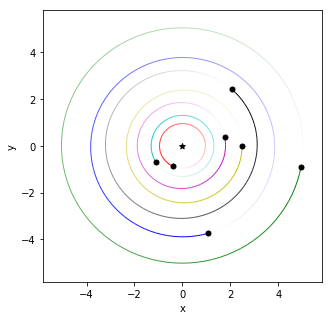

In [28]:
fig = rebound.OrbitPlot(sim, color=True)

# Make plots manually with helper functions

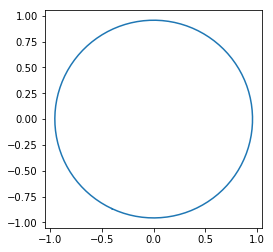

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
o = np.array(sim.particles[1].sample_orbit())
ax.plot(o[:,0], o[:,1])
ax.set_aspect('equal')

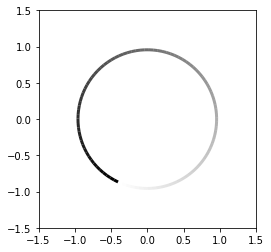

In [26]:
from rebound.plotting import fading_line
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots()
o = np.array(sim.particles[1].sample_orbit())
lc = fading_line(o[:,0], o[:,1], alpha_initial=1., lw=3)
ax.add_collection(lc)
ax.set_xlim([-1.5,1.5])
ax.set_ylim([-1.5,1.5])
ax.set_aspect('equal')

# First integrate backwards for the length of the integration we want to do, so that when we go forwards we end up at time 0 to match up with movie

In [29]:
sim.integrate(-2)

# This is a hack to get around the fact that the current code does not handle negative times correctly

In [30]:
sim.t = 0

# This makes theta vary from inclined to face on over the integration. Can do a fixed inclination with a single frames.theta = 60.*np.pi/180

In [31]:
frames = ss.FrameRecorder(sim, time_per_sec=0.5)
frames.color = ['red','darkorange','forestgreen','cyan','deepskyblue','violet','darkviolet']

Nout = 20
times = np.linspace(0, 2, Nout)
thetas = np.linspace(60.*np.pi/180., 0, Nout)

for i, time in enumerate(times):
    frames.theta = thetas[i]
    sim.integrate(time) # integrate for two outer planet orbits

# Helper functions for rotations. Set up to just do a simple rotation around the x axis by theta. Let me know if you want me to generalize this

In [32]:
def rotate_particles(sim, theta):
    xyz = np.zeros((sim.N, 3))
    for i, p in enumerate(sim.particles):
        xyz[i][0] = p.x
        xyz[i][1] = p.y
        xyz[i][2] = p.z
    rotmatrix = np.array([[1,0,0], [0,np.cos(theta),-np.sin(theta)], [0,np.sin(theta),np.cos(theta)]])
    return rotmatrix.dot(xyz.T).T

def rotate_orbit(o, theta):
    rotmatrix = np.array([[1,0,0], [0,np.cos(theta),-np.sin(theta)], [0,np.sin(theta),np.cos(theta)]])
    return rotmatrix.dot(o.T).T

# Example of a rotation

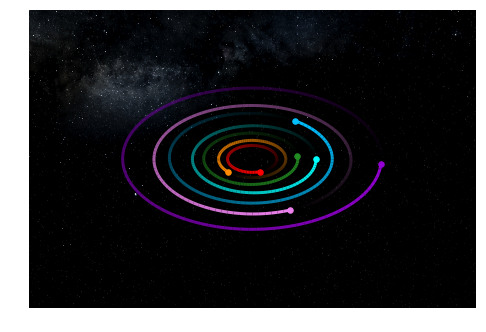

In [49]:
import matplotlib.pyplot as plt
from rebound.plotting import fading_line
from scipy.misc import imread

def plot_event(params):
    fig, ax = plt.subplots(figsize=(8,8))
    fig.axes[0].axis('off') # turn off axes
    colors = params['color']                       # colors for each of the particles (including the star)
    theta=params['theta']
    lw=3. # line width
    
    sim = rebound.Simulation.from_file(params['filename'])
    ps = sim.particles
    
    # set plot boundaries to larger than outermost planet
    lim = 1.15*ps[-1].a
    ax.set_xlim([-1.5*lim, 1.5*lim])
    ax.set_ylim([-lim, lim])
    
    # get rotated xyz coordinates for all bodies
    xyz = rotate_particles(sim, theta)
    # plot star
    ax.scatter(xyz[0][0], xyz[0][1], marker="*", s=35*lw, facecolor="black", edgecolor=None, zorder=3)
    
    for i, p in enumerate(sim.particles[1:]):
        # plot planet
        ax.scatter(xyz[i+1][0], xyz[i+1][1], s=10*lw, facecolor=colors[i], edgecolor=None, zorder=3)
        #plot orbit
        o = np.array(p.sample_orbit())
        o = rotate_orbit(o, theta)
        lc = fading_line(o[:,0], o[:,1], color=colors[i], lw=lw)
        ax.add_collection(lc)
    
    bkg = imread('../images/US_background_image.png')
    ax.imshow(bkg, zorder=0, extent=ax.get_xlim()+ax.get_ylim())

    return fig
    
fig = plot_event(frames.events[0])

# I've tried to comment below what each section of code does so it's hopefully easy to edit

In [36]:
import matplotlib.pyplot as plt
from rebound.plotting import fading_line

def write_png(params):
    fig, ax = plt.subplots(figsize=(8,8))
    fig.axes[0].axis('off') # turn off axes
    colors = params['color']                       # colors for each of the particles (including the star)
    theta=params['theta']
    lw=3. # line width
    
    sim = rebound.Simulation.from_file(params['filename'])
    ps = sim.particles
    
    # set plot boundaries to larger than outermost planet
    lim = 1.15*ps[-1].a
    ax.set_xlim([-lim, lim])
    ax.set_ylim([-lim, lim])
    
    # get rotated xyz coordinates for all bodies
    xyz = rotate_particles(sim, theta)
    # plot star
    ax.scatter(xyz[0][0], xyz[0][1], marker="*", s=35*lw, facecolor="black", edgecolor=None, zorder=3)
    
    for i, p in enumerate(sim.particles[1:]):
        # plot planet
        ax.scatter(xyz[i+1][0], xyz[i+1][1], s=25*lw, facecolor=colors[i], edgecolor=None, zorder=3)
        #plot orbit
        o = np.array(p.sample_orbit())
        o = rotate_orbit(o, theta)
        lc = fading_line(o[:,0], o[:,1], color=colors[i], lw=lw)
        ax.add_collection(lc)
        
    fig.savefig('tmp/pngs/{0:0=5d}.png'.format(params['frame_ctr']))
    plt.close(fig)

In [37]:
params = frames.events[0]
write_png(params)
from subprocess import call
call("open tmp/pngs/{0:0=5d}.png".format(params['frame_ctr']), shell=True)

0

We now write all the frames using our function. Making matplotlib plots is not optimized for efficiency, so it's quite slow. We therefore generate them in parallel.

In [53]:
%%time
from subprocess import call
call("rm -f tmp/pngs/*", shell=True)
pool = rebound.InterruptiblePool()
res = pool.map(write_png, frames.events)

CPU times: user 44.8 ms, sys: 47.3 ms, total: 92.1 ms
Wall time: 8.15 s


# Outputting a movie file

You now have all the frames for the movie in `systemsounds/jupyter_examples/tmp/pngs`, and can stitch them together into a movie using your favorite software. For some ideas and options, see [MovieEditingSoftware.ipynb](MovieEditingSoftware.ipynb)

# More advanced example

Everyone will want to do something slightly differently, so rather than building up a complicated framework with many options, the idea is that people can contribute examples to this repository that others can draw on to make their own custom movies. We're looking forward to seeing what people come up with! For a more complicated example see [TRAPPIST1.ipynb](TRAPPIST1.ipynb)